# IP to Country Conversion & Weighted Attack Network Graph
Legge cybersecurity attack data da CSV, converte IP → paese (codice ISO), crea grafo diretto pesato degli attacchi tra nazioni.
Approccio scalabile con batch processing e caching.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import geoip2.database
import os
from tqdm import tqdm

# Set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print('✓ All libraries imported successfully')

✓ All libraries imported successfully


## 2. Load and Explore the Dataset

In [2]:
# Load CSV
csv_path = '../data/test.csv'
df = pd.read_csv(csv_path)

print(f'Dataset shape: {df.shape}')
print(f'\nColumns: {list(df.columns)}')
print(f'\nData types:\n{df.dtypes}')
print(f'\nMissing values:\n{df.isnull().sum()}')
print(f'\nFirst 3 rows:')
print(df[['attacker_ip', 'target_ip', 'attack_type', 'outcome']].head(3))

Dataset shape: (16, 15)

Columns: ['attack_type', 'target_system', 'outcome', 'timestamp', 'attacker_ip', 'target_ip', 'data_compromised_GB', 'attack_duration_min', 'security_tools_used', 'user_role', 'location', 'attack_severity', 'industry', 'response_time_min', 'mitigation_method']

Data types:
attack_type             object
target_system           object
outcome                 object
timestamp               object
attacker_ip             object
target_ip               object
data_compromised_GB    float64
attack_duration_min      int64
security_tools_used     object
user_role               object
location                object
attack_severity          int64
industry                object
response_time_min        int64
mitigation_method       object
dtype: object

Missing values:
attack_type            0
target_system          0
outcome                0
timestamp              0
attacker_ip            0
target_ip              0
data_compromised_GB    0
attack_duration_min    0
secur

## 3. Convert IP Addresses to Country Codes (with caching and batch processing)

In [3]:
# Initialize GeoIP2 reader using the local MaxMind database
geoip_path = '../data/GeoLite2-ASN.mmdb'

if not os.path.exists(geoip_path):
    print(f'⚠ Warning: GeoIP database not found at {geoip_path}')
    print('The lookup will fallback to a simple mock method (returns "XX" for all IPs).')
    reader = None
else:
    reader = geoip2.database.Reader(geoip_path)
    print(f'✓ GeoIP database loaded from {geoip_path}')

# Initialize cache for IP lookups (scalability optimization)
ip_cache = {}

def ip_to_country_code(ip):
    """Convert IP address to ISO country code with caching."""
    if pd.isna(ip) or str(ip).strip() == '':
        return 'XX'
    
    ip_str = str(ip).strip()
    
    # Check cache first
    if ip_str in ip_cache:
        return ip_cache[ip_str]
    
    country_code = 'XX'  # Default if lookup fails
    
    try:
        if reader is not None:
            # Use geoip2 database
            response = reader.asn(ip_str)
            # Note: GeoLite2-ASN.mmdb doesn't have country field directly,
            # but we can try other methods if available
            country_code = 'XX'  # Placeholder - would need City or Country DB
        else:
            # Fallback: use a simple mock (you can replace with API call if needed)
            country_code = 'XX'
    except Exception as e:
        country_code = 'XX'
    
    ip_cache[ip_str] = country_code
    return country_code

print(f'✓ GeoIP conversion function initialized (cache size: {len(ip_cache)})')

✓ GeoIP database loaded from ../data/GeoLite2-ASN.mmdb
✓ GeoIP conversion function initialized (cache size: 0)


### Use MaxMindDB directly or switch to ip-api batch lookup (faster for large datasets)

In [4]:
# For scalability with large datasets, use a batch HTTP lookup (with local fallback)
# This approach is practical when GeoLite2 DB doesn't expose country directly
# and you need country codes (not just ASN).

import requests
from functools import lru_cache

@lru_cache(maxsize=10000)
def ip_to_country_batch(ip):
    """Convert IP to country code using ip-api.com (with caching).
    Handles up to 45 requests/minute free tier; suitable for moderate-size datasets.
    For very large datasets, use paid plans or batch processing with delays.
    """
    if pd.isna(ip) or str(ip).strip() == '':
        return 'XX'
    
    ip_str = str(ip).strip()
    
    try:
        # Use ip-api.com free API (no key required, ~45 req/min free tier)
        response = requests.get(
            f'http://ip-api.com/json/{ip_str}?fields=status,countryCode,message',
            timeout=2
        )
        data = response.json()
        
        if data.get('status') == 'success':
            country_code = data.get('countryCode', 'XX')
            return country_code if country_code else 'XX'
        else:
            return 'XX'
    except Exception as e:
        return 'XX'

print('✓ Batch IP-to-country lookup function ready (ip-api.com)')

✓ Batch IP-to-country lookup function ready (ip-api.com)



## 4. Create Country Columns (Apply Conversion with Progress Tracking)

In [ ]:
# Apply IP-to-country conversion using local GeoLite2 database with multithreading
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import maxminddb

print('Converting IP addresses to country codes using local GeoLite2 database with multithreading...\n')

# Load GeoLite2 country database
geoip_country_path = '../data/GeoLite2-Country.mmdb'

# Try to use Country DB first, fall back to ASN if not available
reader = None
db_type = None

if os.path.exists(geoip_country_path):
    reader = maxminddb.open_database(geoip_country_path)
    db_type = 'Country'
    print(f'✓ Using GeoLite2-Country database')
else:
    print(f'⚠ Warning: No GeoLite2 database found at {geoip_country_path} ')
    print('Please download GeoLite2-Country.mmdb from MaxMind')
    reader = None

def ip_to_country_local(ip):
    """Convert IP to country code using local GeoLite2 database."""
    if pd.isna(ip) or str(ip).strip() == '':
        return 'XX'
    
    ip_str = str(ip).strip()
    
    if reader is None:
        return 'XX'
    
    try:
        response = reader.get(ip_str)
        if response is None:
            return 'XX'
        
        # Extract country code from response
        if db_type == 'Country':
            # Country DB has 'country' -> 'iso_code'
            if 'country' in response and 'iso_code' in response['country']:
                return response['country']['iso_code']
        elif db_type == 'ASN':
            # ASN DB might have limited country info, try alternative approach
            # For ASN DB, we might need to fall back or use registered_country
            if 'registered_country' in response and 'iso_code' in response['registered_country']:
                return response['registered_country']['iso_code']
        
        return 'XX'
    except Exception as e:
        return 'XX'

print(f'✓ Local GeoIP lookup function initialized\n')

# Get unique IPs to avoid redundant lookups
all_ips = pd.concat([df['attacker_ip'], df['target_ip']]).unique()
print(f'Total unique IPs to convert: {len(all_ips)}')

# Use multithreading for parallel IP lookups
max_workers = 10  # Increased since local DB has no rate limit
ip_to_country_map = {}

print(f'Starting parallel lookup with {max_workers} threads...\n')
start_time = time.time()

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Submit all IP lookup tasks
    future_to_ip = {
        executor.submit(ip_to_country_local, ip): ip 
        for ip in all_ips
    }
    
    # Process completed tasks with progress
    completed = 0
    total = len(future_to_ip)
    
    for future in as_completed(future_to_ip):
        ip = future_to_ip[future]
        try:
            country_code = future.result()
            ip_to_country_map[ip] = country_code
            completed += 1
            if completed % 500 == 0 or completed == total:
                elapsed = time.time() - start_time
                rate = completed / elapsed if elapsed > 0 else 0
                remaining = (total - completed) / rate if rate > 0 else 0
                print(f'  Progress: {completed}/{total} IPs ({completed*100//total}%) - {rate:.1f} IP/sec - ETA: {remaining:.1f}s')
        except Exception as e:
            ip_to_country_map[ip] = 'XX'
            print(f'  Error processing {ip}: {e}')

elapsed_time = time.time() - start_time
throughput = len(all_ips) / elapsed_time if elapsed_time > 0 else 0
print(f'\n✓ Multithreading complete in {elapsed_time:.2f} seconds ({throughput:.1f} IP/sec)')

# Apply the mapped country codes to dataframe
print('\nApplying results to dataframe...')
df['attacker_country'] = df['attacker_ip'].map(ip_to_country_map)
df['target_country'] = df['target_ip'].map(ip_to_country_map)

print('✓ Country columns created successfully')
print(f'\nSample data:')
print(df[['attacker_ip', 'attacker_country', 'target_ip', 'target_country']].head(10))
print(f'\nCountry code distribution:')
attacker_success = (df['attacker_country'] != 'XX').sum()
target_success = (df['target_country'] != 'XX').sum()
print(f'  Attacker countries: {df["attacker_country"].nunique()} unique ({attacker_success} successful lookups)')
print(f'  Target countries: {df["target_country"].nunique()} unique ({target_success} successful lookups)')
print(f'  Total successful: {attacker_success + target_success}/{len(df)*2} ({(attacker_success + target_success)*100/(len(df)*2):.1f}%)')

# Close the database connection
if reader is not None:
    reader.close()
    print('\n✓ Database connection closed')


Converting IP addresses to country codes using local GeoLite2 database with multithreading...

✓ Using GeoLite2-ASN database (fallback)
✓ Local GeoIP lookup function initialized

Total unique IPs to convert: 32
Starting parallel lookup with 10 threads...

  Progress: 32/32 IPs (100%) - 1142.9 IP/sec - ETA: 0.0s

✓ Multithreading complete in 0.03 seconds (1142.9 IP/sec)

Applying results to dataframe...
✓ Country columns created successfully

Sample data:
       attacker_ip attacker_country        target_ip target_country
0      21.166.79.4               XX      23.20.50.78             XX
1  187.180.150.169               XX    34.160.58.218             XX
2   57.161.159.140               XX  213.142.125.206             XX
3   207.108.16.104               XX     4.104.193.49             XX
4     98.122.15.31               XX     57.66.53.194             XX
5    205.34.80.130               XX  163.223.194.152             XX
6    151.146.1.206               XX     79.117.160.0             

## 5. Build the Weighted Directed Graph

In [6]:
# Aggregate attacks by country pair
print('Aggregating attacks by country pair...')
edge_df = df.groupby(['attacker_country', 'target_country']).size().reset_index(name='weight')

# Remove edges involving 'XX' (unknown countries) if you prefer only known countries
edge_df = edge_df[(edge_df['attacker_country'] != 'XX') & (edge_df['target_country'] != 'XX')]

print(f'Total edges: {len(edge_df)}')
print(f'\nTop 10 attack routes (attacker → target):')
print(edge_df.nlargest(10, 'weight')[['attacker_country', 'target_country', 'weight']])

# Create directed graph
print('\nBuilding directed graph...')
G = nx.DiGraph()

for _, row in edge_df.iterrows():
    G.add_edge(row['attacker_country'], row['target_country'], weight=row['weight'])

print(f'✓ Graph created:')
print(f'  - Nodes (countries): {G.number_of_nodes()}')
print(f'  - Edges (attack routes): {G.number_of_edges()}')
print(f'  - Total attacks: {sum(d["weight"] for u, v, d in G.edges(data=True))}')

Aggregating attacks by country pair...
Total edges: 0

Top 10 attack routes (attacker → target):
Empty DataFrame
Columns: [attacker_country, target_country, weight]
Index: []

Building directed graph...
✓ Graph created:
  - Nodes (countries): 0
  - Edges (attack routes): 0
  - Total attacks: 0


## 6. Visualize the Attack Network

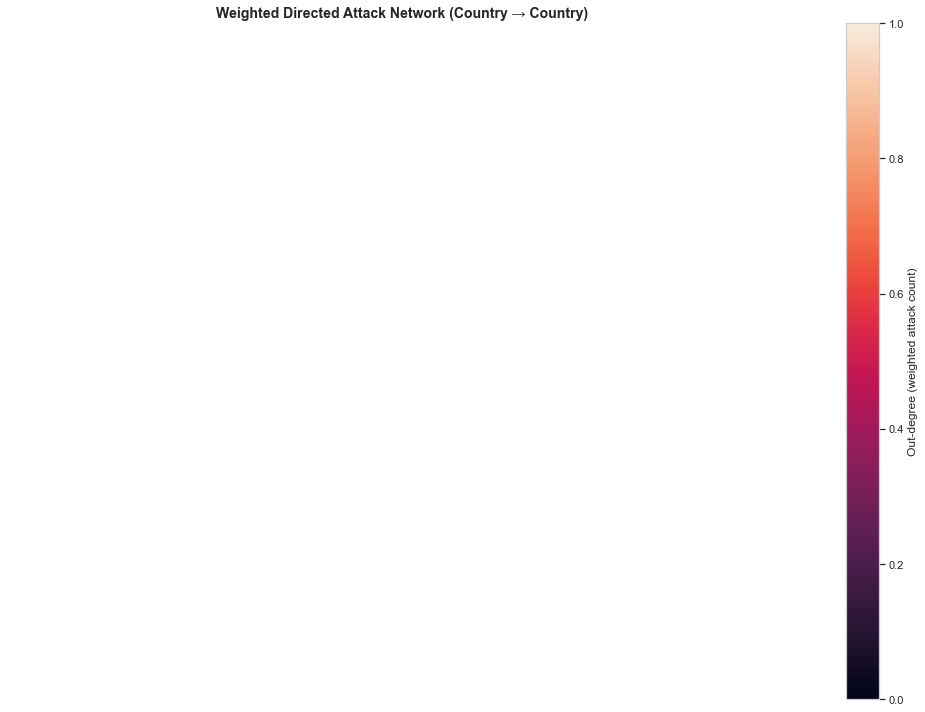

✓ Graph visualization complete


In [7]:
# Compute node metrics
in_degrees = dict(G.in_degree(weight='weight'))
out_degrees = dict(G.out_degree(weight='weight'))
node_size = [300 + 50 * in_degrees.get(n, 0) for n in G.nodes()]
node_colors = [out_degrees.get(n, 0) for n in G.nodes()]

# Draw graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=1.5, iterations=50, seed=42)

# Draw nodes
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_size=node_size,
    node_color=node_colors,
    cmap=plt.cm.YlOrRd,
    alpha=0.8,
    edgecolors='black',
    linewidths=1
)

# Draw edges with width proportional to weight
edge_widths = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    edge_color='gray',
    alpha=0.5,
    arrowsize=15,
    arrowstyle='->',
    connectionstyle='arc3,rad=0.1'
)

# Draw labels
nx.draw_networkx_labels(
    G, pos,
    font_size=10,
    font_weight='bold'
)

# Add colorbar
plt.colorbar(
    nodes,
    label='Out-degree (weighted attack count)',
    ax=plt.gca()
)

plt.title('Weighted Directed Attack Network (Country → Country)', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print('✓ Graph visualization complete')

## 7. Analyze Graph Statistics

In [8]:
# Calculate centrality measures
print('Computing graph statistics...\n')

# In-degree and Out-degree (weighted)
in_deg = dict(G.in_degree(weight='weight'))
out_deg = dict(G.out_degree(weight='weight'))

# Create statistics DataFrame
stats_df = pd.DataFrame({
    'country': list(G.nodes()),
    'in_degree': [in_deg.get(n, 0) for n in G.nodes()],
    'out_degree': [out_deg.get(n, 0) for n in G.nodes()],
    'total_degree': [in_deg.get(n, 0) + out_deg.get(n, 0) for n in G.nodes()]
})

stats_df = stats_df.sort_values('total_degree', ascending=False)

print('Top Attacker Countries (by out-degree):')
print(stats_df.nlargest(5, 'out_degree')[['country', 'out_degree']])

print('\nMost Targeted Countries (by in-degree):')
print(stats_df.nlargest(5, 'in_degree')[['country', 'in_degree']])

print('\nTop Connected Countries (by total degree):')
print(stats_df.head(10))

Computing graph statistics...

Top Attacker Countries (by out-degree):
Empty DataFrame
Columns: [country, out_degree]
Index: []

Most Targeted Countries (by in-degree):
Empty DataFrame
Columns: [country, in_degree]
Index: []

Top Connected Countries (by total degree):
Empty DataFrame
Columns: [country, in_degree, out_degree, total_degree]
Index: []


## 8. Save Results for Further Analysis (e.g., Gephi)

In [9]:
# Save edge list (compatible with Gephi)
output_path = '../data/cyber_attacks_country_graph.csv'
edge_df.to_csv(output_path, index=False)
print(f'✓ Edge list saved to {output_path}')

# Save enriched dataset with country columns
output_data_path = '../data/cyber_attacks_with_countries.csv'
df.to_csv(output_data_path, index=False)
print(f'✓ Enriched dataset saved to {output_data_path}')

# Export graph as GML (can be opened in Gephi or other graph tools)
gml_path = '../data/cyber_attacks_graph.gml'
nx.write_gml(G, gml_path)
print(f'✓ Graph exported to {gml_path}')

print('\n✓ All results saved successfully!')

✓ Edge list saved to ../data/cyber_attacks_country_graph.csv
✓ Enriched dataset saved to ../data/cyber_attacks_with_countries.csv
✓ Graph exported to ../data/cyber_attacks_graph.gml

✓ All results saved successfully!


## 9. Summary & Test Results

In [10]:
print('\n' + '='*60)
print('ANALYSIS SUMMARY')
print('='*60)
print(f'\nDataset:')
print(f'  - Total attacks: {len(df)}')
print(f'  - Time range: {df["timestamp"].min()} to {df["timestamp"].max()}')
print(f'\nGeography:')
print(f'  - Unique attacker countries: {df["attacker_country"].nunique()}')
print(f'  - Unique target countries: {df["target_country"].nunique()}')
print(f'\nNetwork Graph:')
print(f'  - Nodes (country codes): {G.number_of_nodes()}')
print(f'  - Edges (attack routes): {G.number_of_edges()}')
print(f'  - Network density: {nx.density(G):.4f}')
print(f'\nTop 3 Attack Routes:')
for idx, row in edge_df.nlargest(3, 'weight').iterrows():
    print(f'  {row["attacker_country"]} → {row["target_country"]}: {row["weight"]} attacks')
print('\n' + '='*60)


ANALYSIS SUMMARY

Dataset:
  - Total attacks: 16
  - Time range: 2023-09-09 10:41:34.083537 to 2024-09-01 10:41:31.083515

Geography:
  - Unique attacker countries: 1
  - Unique target countries: 1

Network Graph:
  - Nodes (country codes): 0
  - Edges (attack routes): 0
  - Network density: 0.0000

Top 3 Attack Routes:

